In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2025-11-22 18:52:09.702900: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
def load_batch(file_path):
    """Load a single batch file from CIFAR-10 dataset."""
    with open(file_path, 'rb') as f:
        data_dict = pickle.load(f, encoding='bytes')
    return data_dict

In [5]:
def load_cifar10(data_path):
    """Load the complete CIFAR-10 dataset."""
    train_data = []
    train_labels = []
    
    for i in range(1, 6):
        file_name = os.path.join(data_path, f'data_batch_{i}')
        batch = load_batch(file_name)
        train_data.append(batch[b'data'])
        train_labels += batch[b'labels']
        
    train_data = np.concatenate(train_data)
    train_labels = np.array(train_labels)
    
    test_batch = load_batch(os.path.join(data_path, 'test_batch'))
    test_data = test_batch[b'data']
    test_labels = np.array(test_batch[b'labels'])
    
    meta_data = load_batch(os.path.join(data_path, 'batches.meta'))
    label_names = [label.decode('utf-8') for label in meta_data[b'label_names']]
    
    train_data = train_data.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    test_data = test_data.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    
    return (train_data, train_labels), (test_data, test_labels), label_names

In [6]:
def build_transfer_learning_model(base_model_name='MobileNetV2', input_shape=(32, 32, 3), num_classes=10):
    """
    Build a transfer learning model using a pre-trained base.
    
    Args:
        base_model_name: 'VGG16', 'ResNet50', or 'MobileNetV2'
        input_shape: Input image shape
        num_classes: Number of output classes
    
    Returns:
        Compiled Keras model
    """
    # Load pre-trained base model (without top layers)
    if base_model_name == 'VGG16':
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    elif base_model_name == 'ResNet50':
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    elif base_model_name == 'MobileNetV2':
        base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    else:
        raise ValueError(f"Unknown base model: {base_model_name}")
    
    # Freeze base model layers
    base_model.trainable = False
    
    # Build model
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

In [7]:
def plot_training_history(history, model_name):
    """Plot training and validation accuracy/loss."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    axes[0].plot(history.history['accuracy'], label='Train Accuracy')
    axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[0].set_title(f'{model_name} - Model Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True)
    
    axes[1].plot(history.history['loss'], label='Train Loss')
    axes[1].plot(history.history['val_loss'], label='Validation Loss')
    axes[1].set_title(f'{model_name} - Model Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.show()

In [8]:
def plot_confusion_matrix(y_true, y_pred, label_names, model_name):
    """Plot confusion matrix."""
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=label_names, yticklabels=label_names)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

TensorFlow version: 2.16.2
Using base model: MobileNetV2
Loading CIFAR-10 dataset...
Training data shape: (40000, 32, 32, 3)
Validation data shape: (10000, 32, 32, 3)
Test data shape: (10000, 32, 32, 3)
Building transfer learning model with MobileNetV2...


/var/folders/k3/c13ddj7d46n3kbwd2zx925mm0000gn/T/ipykernel_37921/1290210862.py:19: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 1, 1, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,589,514 (9.88 MB)

 Trainable params: 331,018 (1.26 MB)

 Non-trainable params: 2,258,496 (8.62 MB)

Training model...
Epoch 1/30
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.2128 - loss: 2.3800
Epoch 1: val_accuracy improved from None to 0.31160, saving model to ../data/best_mobilenetv2_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 48s 67ms/step - accuracy: 0.2389 - loss: 2.1846 - val_accuracy: 0.3116 - val_loss: 1.9362
Epoch 2/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.2708 - loss: 1.9846
Epoch 2: val_accuracy improved from 0.31160 to 0.31610, saving model to ../data/best_mobilenetv2_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 42s 68ms/step - accuracy: 0.2783 - loss: 1.9708 - val_accuracy: 0.3161 - val_loss: 1.8917
Epoch 3/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.2900 - loss: 1.9444
Epoch 3: val_accuracy improved from 0.31610 to 0.32160, saving model to ../data/best_mobilenetv2_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 42s 67ms/step - accuracy: 0.2900 - loss: 1.9442 - val_accuracy: 0.3216 - val_loss: 1.8775
Epoch 4/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.2932 - loss: 1.9320
Epoch 4: val_accuracy improved from 0.32160 to 0.32650, saving model to ../data/best_mobilenetv2_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 44s 70ms/step - accuracy: 0.2937 - loss: 1.9324 - val_accuracy: 0.3265 - val_loss: 1.8589
Epoch 5/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.3012 - loss: 1.9230
Epoch 5: val_accuracy improved from 0.32650 to 0.32970, saving model to ../data/best_mobilenetv2_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 45s 72ms/step - accuracy: 0.3000 - loss: 1.9197 - val_accuracy: 0.3297 - val_loss: 1.8514
Epoch 6/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.2982 - loss: 1.9190
Epoch 6: val_accuracy improved from 0.32970 to 0.33310, saving model to ../data/best_mobilenetv2_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 48s 77ms/step - accuracy: 0.2988 - loss: 1.9159 - val_accuracy: 0.3331 - val_loss: 1.8407
Epoch 7/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.3088 - loss: 1.9061
Epoch 7: val_accuracy did not improve from 0.33310
625/625 ━━━━━━━━━━━━━━━━━━━━ 50s 81ms/step - accuracy: 0.3031 - loss: 1.9138 - val_accuracy: 0.3293 - val_loss: 1.8423
Epoch 8/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.3019 - loss: 1.9098
Epoch 8: val_accuracy improved from 0.33310 to 0.33660, saving model to ../data/best_mobilenetv2_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 53s 84ms/step - accuracy: 0.3025 - loss: 1.9108 - val_accuracy: 0.3366 - val_loss: 1.8322
Epoch 9/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.3020 - loss: 1.9018
Epoch 9: val_accuracy improved from 0.33660 to 0.33730, saving model to ../data/best_mobilenetv2_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 47s 76ms/step - accuracy: 0.3018 - loss: 1.9047 - val_accuracy: 0.3373 - val_loss: 1.8336
Epoch 10/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.3018 - loss: 1.9000
Epoch 10: val_accuracy did not improve from 0.33730
625/625 ━━━━━━━━━━━━━━━━━━━━ 48s 76ms/step - accuracy: 0.3028 - loss: 1.8998 - val_accuracy: 0.3360 - val_loss: 1.8354
Epoch 11/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.3070 - loss: 1.8972
Epoch 11: val_accuracy improved from 0.33730 to 0.33860, saving model to ../data/best_mobilenetv2_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 47s 76ms/step - accuracy: 0.3072 - loss: 1.8970 - val_accuracy: 0.3386 - val_loss: 1.8290
Epoch 12/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.3121 - loss: 1.8906
Epoch 12: val_accuracy improved from 0.33860 to 0.34000, saving model to ../data/best_mobilenetv2_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 53s 85ms/step - accuracy: 0.3116 - loss: 1.8943 - val_accuracy: 0.3400 - val_loss: 1.8294
Epoch 13/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.3078 - loss: 1.8915
Epoch 13: val_accuracy did not improve from 0.34000
625/625 ━━━━━━━━━━━━━━━━━━━━ 58s 93ms/step - accuracy: 0.3091 - loss: 1.8932 - val_accuracy: 0.3368 - val_loss: 1.8300
Epoch 14/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.3074 - loss: 1.8949
Epoch 14: val_accuracy improved from 0.34000 to 0.34540, saving model to ../data/best_mobilenetv2_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 60s 96ms/step - accuracy: 0.3088 - loss: 1.8931 - val_accuracy: 0.3454 - val_loss: 1.8185
Epoch 15/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.3120 - loss: 1.8875
Epoch 15: val_accuracy did not improve from 0.34540
625/625 ━━━━━━━━━━━━━━━━━━━━ 59s 95ms/step - accuracy: 0.3122 - loss: 1.8883 - val_accuracy: 0.3431 - val_loss: 1.8249
Epoch 16/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.3162 - loss: 1.8793
Epoch 16: val_accuracy did not improve from 0.34540
625/625 ━━━━━━━━━━━━━━━━━━━━ 64s 102ms/step - accuracy: 0.3161 - loss: 1.8845 - val_accuracy: 0.3432 - val_loss: 1.8224
Epoch 17/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.3093 - loss: 1.8883
Epoch 17: val_accuracy improved from 0.34540 to 0.34560, saving model to ../data/best_mobilenetv2_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 64s 102ms/step - accuracy: 0.3106 - loss: 1.8907 - val_accuracy: 0.3456 - val_loss: 1.8188
Epoch 18/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.3141 - loss: 1.8839
Epoch 18: val_accuracy did not improve from 0.34560
625/625 ━━━━━━━━━━━━━━━━━━━━ 63s 101ms/step - accuracy: 0.3113 - loss: 1.8864 - val_accuracy: 0.3405 - val_loss: 1.8168
Epoch 19/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.3130 - loss: 1.8924
Epoch 19: val_accuracy improved from 0.34560 to 0.34830, saving model to ../data/best_mobilenetv2_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 70s 111ms/step - accuracy: 0.3133 - loss: 1.8876 - val_accuracy: 0.3483 - val_loss: 1.8098
Epoch 20/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.3135 - loss: 1.8816
Epoch 20: val_accuracy did not improve from 0.34830
625/625 ━━━━━━━━━━━━━━━━━━━━ 75s 119ms/step - accuracy: 0.3155 - loss: 1.8801 - val_accuracy: 0.3411 - val_loss: 1.8147
Epoch 21/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.3119 - loss: 1.8865
Epoch 21: val_accuracy did not improve from 0.34830
625/625 ━━━━━━━━━━━━━━━━━━━━ 78s 125ms/step - accuracy: 0.3132 - loss: 1.8815 - val_accuracy: 0.3425 - val_loss: 1.8126
Epoch 22/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.3148 - loss: 1.8794
Epoch 22: val_accuracy did not improve from 0.34830
625/625 ━━━━━━━━━━━━━━━━━━━━ 84s 134ms/step - accuracy: 0.3119 - loss: 1.8822 - val_accuracy: 0.3440 - val_loss: 1.8120
Epoch 23/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.3151 - loss: 1.8817
Epoch 23: 

625/625 ━━━━━━━━━━━━━━━━━━━━ 89s 143ms/step - accuracy: 0.3156 - loss: 1.8792 - val_accuracy: 0.3492 - val_loss: 1.8111
Epoch 24/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.3134 - loss: 1.8816
Epoch 24: val_accuracy did not improve from 0.34920
625/625 ━━━━━━━━━━━━━━━━━━━━ 91s 146ms/step - accuracy: 0.3153 - loss: 1.8813 - val_accuracy: 0.3377 - val_loss: 1.8141
Epoch 25/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.3223 - loss: 1.8695
Epoch 25: val_accuracy improved from 0.34920 to 0.35010, saving model to ../data/best_mobilenetv2_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 79s 127ms/step - accuracy: 0.3205 - loss: 1.8758 - val_accuracy: 0.3501 - val_loss: 1.7990
Epoch 26/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.3155 - loss: 1.8756
Epoch 26: val_accuracy did not improve from 0.35010
625/625 ━━━━━━━━━━━━━━━━━━━━ 73s 117ms/step - accuracy: 0.3166 - loss: 1.8778 - val_accuracy: 0.3396 - val_loss: 1.8094
Epoch 27/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.3177 - loss: 1.8726
Epoch 27: val_accuracy did not improve from 0.35010
625/625 ━━━━━━━━━━━━━━━━━━━━ 74s 118ms/step - accuracy: 0.3162 - loss: 1.8759 - val_accuracy: 0.3436 - val_loss: 1.8059
Epoch 28/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.3176 - loss: 1.8651
Epoch 28: val_accuracy did not improve from 0.35010
625/625 ━━━━━━━━━━━━━━━━━━━━ 80s 128ms/step - accuracy: 0.3144 - loss: 1.8755 - val_accuracy: 0.3481 - val_loss: 1.8051
Epoch 29/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.3146 - loss: 1.8745
Epoch 29: 

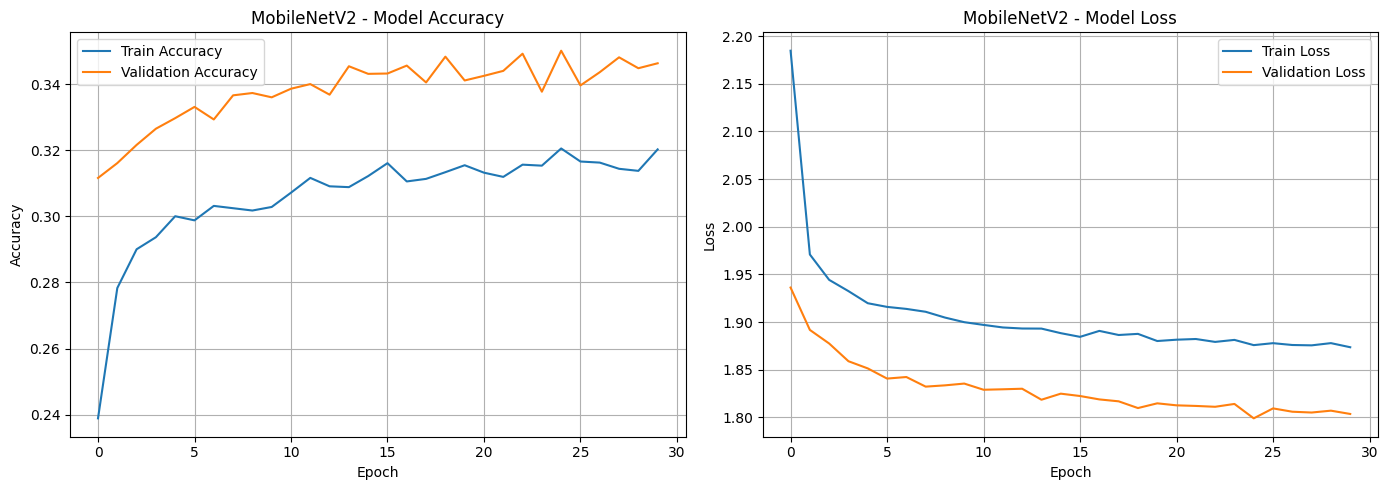

Evaluating on test set...
Test Loss: 1.7975
Test Accuracy: 0.3562
313/313 ━━━━━━━━━━━━━━━━━━━━ 17s 50ms/step

Classification Report:
              precision    recall  f1-score   support

    airplane       0.40      0.40      0.40      1000
  automobile       0.36      0.35      0.36      1000
        bird       0.29      0.16      0.21      1000
         cat       0.32      0.26      0.29      1000
        deer       0.39      0.40      0.39      1000
         dog       0.28      0.41      0.34      1000
        frog       0.48      0.40      0.44      1000
       horse       0.38      0.37      0.37      1000
        ship       0.31      0.40      0.35      1000
       truck       0.37      0.41      0.39      1000

    accuracy                           0.36     10000
   macro avg       0.36      0.36      0.35     10000
weighted avg       0.36      0.36      0.35     10000



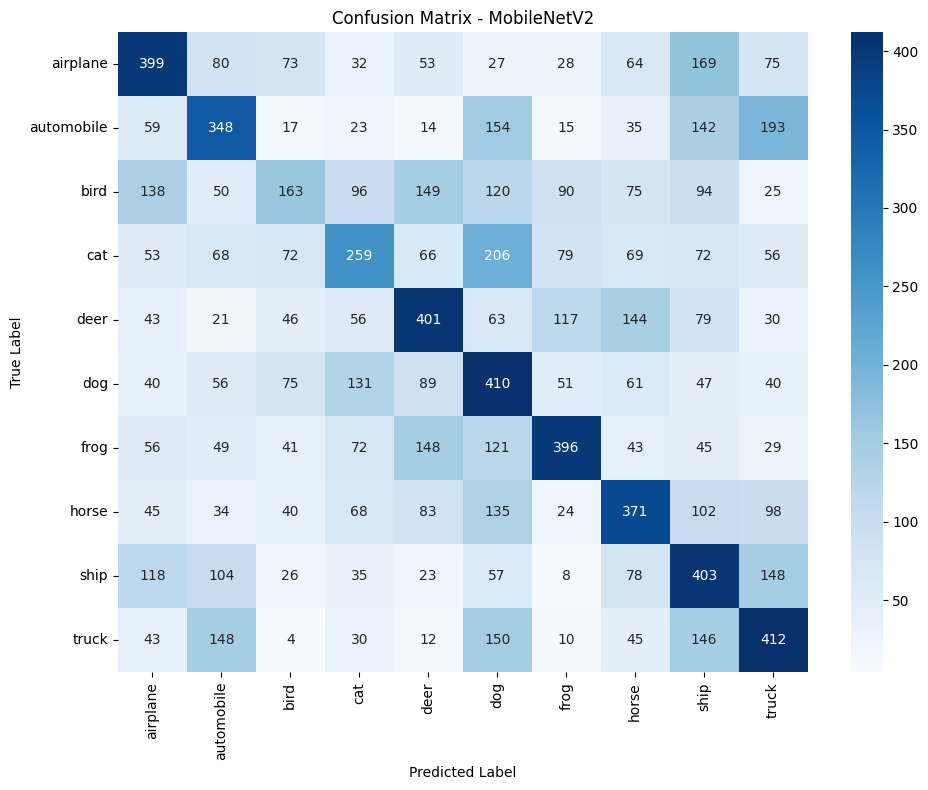

Model and results saved!


In [9]:
if __name__ == '__main__':
    # Configuration
    DATA_PATH = '/Users/nim/Downloads/cifar-10-batches-py'
    BASE_MODEL_NAME = 'MobileNetV2'  # Options: 'VGG16', 'ResNet50', 'MobileNetV2'
    BATCH_SIZE = 64
    EPOCHS = 30
    
    print(f'TensorFlow version: {tf.__version__}')
    print(f'Using base model: {BASE_MODEL_NAME}')
    
    # Load data
    print('Loading CIFAR-10 dataset...')
    (X_train, y_train), (X_test, y_test), label_names = load_cifar10(DATA_PATH)
    
    # Normalize to [0, 1]
    X_train = X_train.astype('float32') / 255.0
    X_test = X_test.astype('float32') / 255.0
    
    # Split into train and validation
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
    )
    
    print(f'Training data shape: {X_train.shape}')
    print(f'Validation data shape: {X_val.shape}')
    print(f'Test data shape: {X_test.shape}')
    
    # Data augmentation
    datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
    )
    datagen.fit(X_train)
    
    # Build model
    print(f'Building transfer learning model with {BASE_MODEL_NAME}...')
    model = build_transfer_learning_model(base_model_name=BASE_MODEL_NAME)
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    model.summary()
    
    # Callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )
    
    model_checkpoint = ModelCheckpoint(
        f'../data/best_{BASE_MODEL_NAME.lower()}_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
    
    # Train
    print('Training model...')
    history = model.fit(
        datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
        epochs=EPOCHS,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping, model_checkpoint],
        verbose=1
    )
    
    # Plot training history
    plot_training_history(history, BASE_MODEL_NAME)
    
    # Evaluate
    print('Evaluating on test set...')
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f'Test Loss: {test_loss:.4f}')
    print(f'Test Accuracy: {test_accuracy:.4f}')
    
    # Predictions
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    # Classification report
    print('\nClassification Report:')
    print(classification_report(y_test, y_pred_classes, target_names=label_names))
    
    # Confusion matrix
    plot_confusion_matrix(y_test, y_pred_classes, label_names, BASE_MODEL_NAME)
    
    # Save model and results
    model.save(f'../data/{BASE_MODEL_NAME.lower()}_final.h5')
    
    results = {
        'model_name': f'Transfer Learning - {BASE_MODEL_NAME}',
        'test_accuracy': test_accuracy,
        'test_loss': test_loss,
        'history': history.history
    }
    
    with open(f'../data/{BASE_MODEL_NAME.lower()}_results.pkl', 'wb') as f:
        pickle.dump(results, f)
    
    print('Model and results saved!')